In [ ]:
import sys, os
sys.path.append(os.path.abspath(".."))

In [ ]:
from src.curve import build_zero_curve, discount_factor, shift_curve
from src.pricing import price_from_curve

In [15]:
# Courbe jouet : maturités (années) et taux continus correspondants
mats = np.array([1, 3, 5, 10], dtype=float)
y_cc = np.array([0.02, 0.022, 0.025, 0.027], dtype=float)

# Construction de r(t)
r = build_zero_curve(mats, y_cc)

# Vérif rapide : r(5y) doit être ~2.5%
r(5.0)

np.float64(0.05449999999999999)

In [16]:
import pandas as pd
from pathlib import Path

# Dossier data (à la racine du repo)
data_path = Path("..") / "data"
data_path.mkdir(parents=True, exist_ok=True)

# Exemple minimal : 3 obligations plain vanilla (coupons annuels)
pf = pd.DataFrame({
    "id":      ["BOND_ZC", "BOND_A", "BOND_B"],
    "face":    [100,       100,      100],
    "coupon":  [0.00,      0.03,     0.05],
    "freq":    [1,         1,        1],          # 1 = annuel
    "maturity":["2028-12-30","2030-12-30","2035-12-30"]
})

csv_file = data_path / "portfolio.csv"
pf.to_csv(csv_file, index=False)
csv_file


PosixPath('../data/portfolio.csv')

In [17]:
import pandas as pd
pf = pd.read_csv("../data/portfolio.csv") 
pf


,id,face,coupon,freq,maturity
0,BOND_ZC,100,0.00,1,2028-12-30
1,BOND_A,100,0.03,1,2030-12-30
2,BOND_B,100,0.05,1,2035-12-30


In [18]:
from src.pricing import price_from_curve

T = 5.0
P_base = price_from_curve(r, [(T, 100.0)])

r_up100 = shift_curve(r, 100)  # +100 bps parallèle
P_up100 = price_from_curve(r_up100, [(T, 100.0)])

P_base, P_up100, P_up100 < P_base  


(76.14734291752053, 72.43359318069157, True)

In [19]:
import datetime as dt
from src.cashflows import to_date, cashflows_plain_vanilla

# On fixe une date de valorisation (V1) pour la reproductibilité :
VAL_DATE = dt.date(2025, 1, 1)

# Exemple : pricer BOND_A du CSV (coupon 3%, annuel)
row = pf.loc[pf["id"] == "BOND_A"].iloc[0]

face = float(row["face"])
coupon = float(row["coupon"])
freq = int(row["freq"])
maturity = to_date(row["maturity"])

flows = cashflows_plain_vanilla(face, coupon, freq, VAL_DATE, maturity)
flows[:5]  


[(0.9945205479452055, 3.0),
 (1.9945205479452055, 3.0),
 (2.9945205479452053, 3.0),
 (3.9972602739726026, 3.0),
 (4.997260273972603, 3.0)]

In [20]:
# Utilise r construit plus haut (mats/y_cc) 
P_base = price_from_curve(r, flows)

r_up = shift_curve(r, 100)
P_up = price_from_curve(r_up, flows)

P_base, P_up, P_up < P_base  


(57.05762351104347, 54.12699698209609, True)

In [21]:
row_zc = pf.loc[pf["id"] == "BOND_ZC"].iloc[0]
flows_zc = cashflows_plain_vanilla(float(row_zc["face"]),
                                   float(row_zc["coupon"]),
                                   int(row_zc["freq"]),
                                   VAL_DATE,
                                   to_date(row_zc["maturity"]))
flows_zc, price_from_curve(r, flows_zc)


([(0.9945205479452055, 0.0),
  (1.9945205479452055, 0.0),
  (2.9945205479452053, 0.0),
  (3.9972602739726026, 100.0)],
 80.78827388612945)

In [22]:
import datetime as dt
import pandas as pd
from src.portfolio import report_portfolio
from src.curve import build_zero_curve

VAL_DATE = dt.date(2025, 1, 1)

# mats = np.array([1,3,5,10], float); y_cc = np.array([0.02,0.022,0.025,0.027], float); r = build_zero_curve(mats, y_cc)

pf = pd.read_csv("../data/portfolio.csv")
rep = report_portfolio(pf, r, VAL_DATE)
rep


,id,price,dv01,dmod,conv,dP_+25bps,dP_+100bps,dv01_contrib_%,price_weight_%
0,BOND_ZC,80.788274,0.032293,0.000400,15.978090,-0.803309,-3.165627,19.762467,32.530528
1,BOND_A,57.057624,0.030148,0.000528,30.095171,-0.748369,-2.930627,18.449906,22.975050
2,BOND_B,110.500131,0.100965,0.000914,94.350686,-2.491834,-9.593303,61.787627,44.494422


In [23]:
tot = pd.Series({
    "price_total": rep["price"].sum(),
    "dv01_total": rep["dv01"].sum(),
    "dP_+25bps_total": rep["dP_+25bps"].sum(),
    "dP_+100bps_total": rep["dP_+100bps"].sum(),
})
tot


price_total         248.346028
dv01_total            0.163407
dP_+25bps_total      -4.043512
dP_+100bps_total    -15.689557
dtype: float64

In [25]:
rep = report_portfolio(pf, r, VAL_DATE)

# formatage léger dans le notebook
cols = ["id","price","dv01","dmod","conv","dP_+25bps","dP_+100bps","dv01_contrib_%","price_weight_%"]
nice = (rep[cols]
        .sort_values("dv01", ascending=False)
        .round({"price":6,"dv01":6,"dmod":6,"conv":6,"dP_+25bps":6,"dP_+100bps":6,"dv01_contrib_%":2,"price_weight_%":2})
        .reset_index(drop=True))
nice

# export
from pathlib import Path
Path("../outputs").mkdir(parents=True, exist_ok=True)
nice.to_csv("../outputs/report_lines.csv", index=False)
rep[["price","dv01","dP_+25bps","dP_+100bps"]].sum().to_csv("../outputs/report_totals.csv")


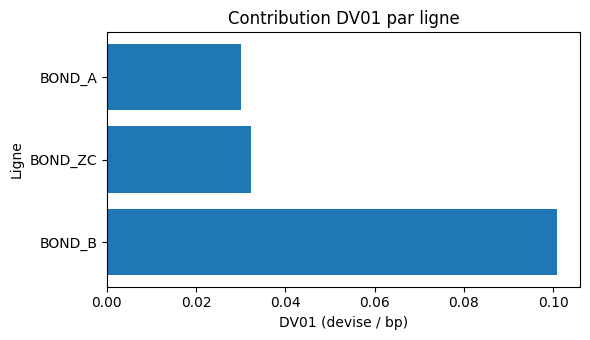

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 3.5))
ax.barh(nice["id"], nice["dv01"])
ax.set_xlabel("DV01 (devise / bp)")
ax.set_ylabel("Ligne")
ax.set_title("Contribution DV01 par ligne")
plt.tight_layout()
plt.savefig("../outputs/dv01_contrib.png", dpi=140)
plt.show()
